<a href="https://colab.research.google.com/github/sumankmaiti/All-in-one/blob/main/heatmap_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow # cv2.imshow does not work on Google Colab notebooks, which is why we are using cv2_imshow instead

In [ ]:
model = VGG16(weights='imagenet')
model.summary()

553476096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
!wget https://indiasendangered.com/wp-content/uploads/2011/09/elephant.jpg
!wget https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12234558/Chinook-On-White-03.jpg
!wget https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png

--2021-10-01 05:37:26--  https://indiasendangered.com/wp-content/uploads/2011/09/elephant.jpg
Resolving indiasendangered.com (indiasendangered.com)... 199.79.62.149
Connecting to indiasendangered.com (indiasendangered.com)|199.79.62.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137242 (134K) [image/jpeg]
Saving to: ‘elephant.jpg’

elephant.jpg        100%[===================>] 134.03K  --.-KB/s    in 0.09s   

2021-10-01 05:37:26 (1.45 MB/s) - ‘elephant.jpg’ saved [137242/137242]

--2021-10-01 05:37:26--  https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12234558/Chinook-On-White-03.jpg
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.75.22
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.75.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25761 (25K) [image/jpeg]
Saving to: ‘Chinook-On-White-03.jpg’

Chinook-On-White-03 100%[===================>]  25.16K  --.-KB/s    in 0.04s   

2021-1

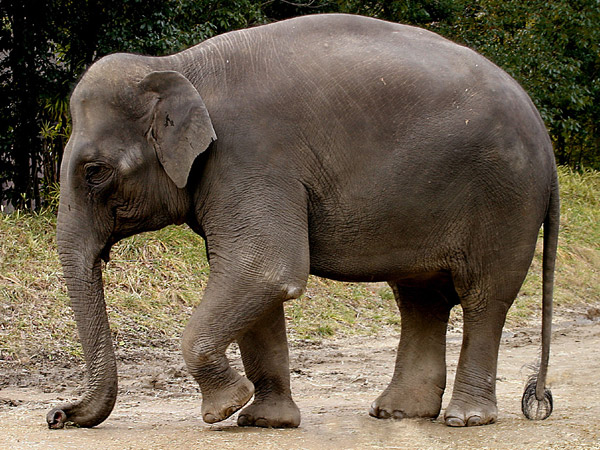

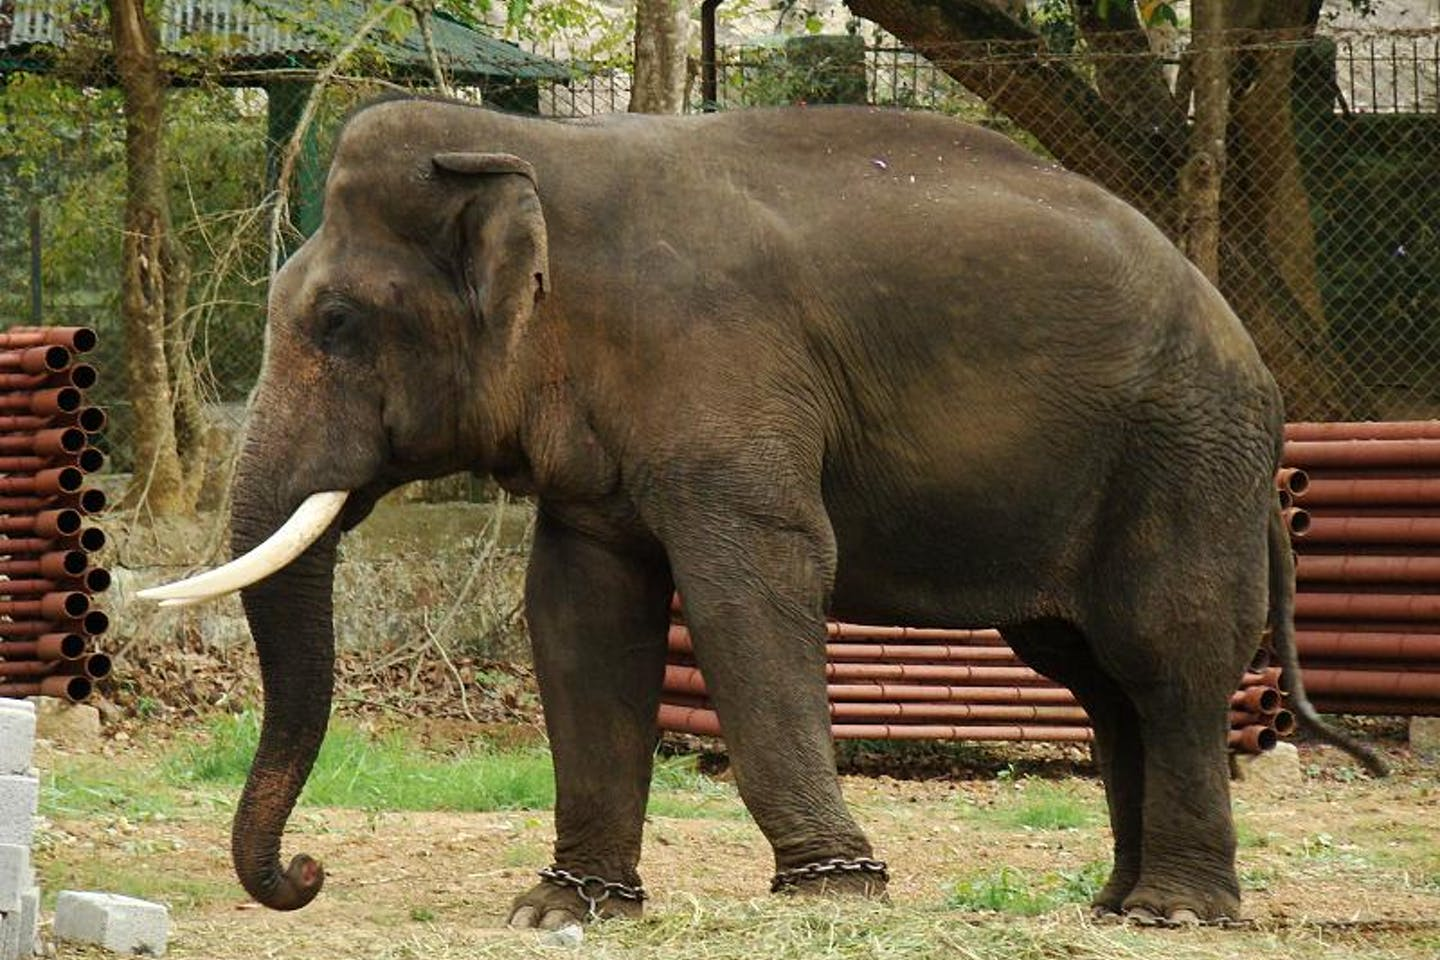

In [ ]:
ORIGINAL = '/content/elephant.jpg' 
ORIGINAL2 = '/content/protect_elephant_reserves_in_india.jpg'
img = image.load_img(ORIGINAL, target_size=(224, 224))
img2 = image.load_img(ORIGINAL2, target_size=(224, 224))
cv2_imshow(cv2.imread(ORIGINAL)) # Visualize image
cv2_imshow(cv2.imread(ORIGINAL2))
x = image.img_to_array(img) # 224, 224, 3
x2 = image.img_to_array(img2)
x = np.expand_dims(x, axis=0) # 1, 224, 224, 3
x2 = np.expand_dims(x2, axis=0)
x = preprocess_input(x) # preprocessing the input for vgg16 model
x2 = preprocess_input(x2)

In [ ]:
# predict the input
preds = model.predict(x)
print(decode_predictions(preds))
preds = model.predict(x2)
print(decode_predictions(preds))

[[('n02504013', 'Indian_elephant', 0.8383319), ('n01871265', 'tusker', 0.13893801), ('n02504458', 'African_elephant', 0.022728862), ('n01704323', 'triceratops', 1.0566192e-06), ('n02480855', 'gorilla', 5.715402e-08)]]
[[('n01871265', 'tusker', 0.6579515), ('n02504013', 'Indian_elephant', 0.323611), ('n02504458', 'African_elephant', 0.018434957), ('n02410509', 'bison', 1.4277663e-06), ('n02408429', 'water_buffalo', 4.5199337e-07)]]


In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('block5_conv3')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x) # for a given input predected output
  print("output shape", model_out.shape)
  print("layer shape", last_conv_layer.shape)
  class_out = model_out[:, np.argmax(model_out[0])]
  print("probablity of the predicted class", class_out)
  grads = tape.gradient(class_out, last_conv_layer)  # compute gradient based on predected probablity and class index
  print("Gradints of w.r.t predicted class", grads.shape) 
  pooled_grads = K.mean(grads, axis=(0, 1, 2))  # Global avarage pooling
  print("Global Avarage pooling", pooled_grads.shape)

heatmap_l = (tf.multiply(pooled_grads, last_conv_layer)) # heatmap by mean along with feature map axis
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1) # heatmap by mean along with feature map axis
print("heatmap shape", heatmap.shape, heatmap_l.shape)

output shape (1, 1000)
layer shape (1, 14, 14, 512)
probablity of the predicted class tf.Tensor([0.8383319], shape=(1,), dtype=float32)
Gradints of w.r.t predicted class (1, 14, 14, 512)
Global Avarage pooling (512,)
heatmap shape (1, 14, 14) (1, 14, 14, 512)


In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('block5_conv3')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x2) # for a given input predected output
  print("output shape", model_out.shape)
  print("layer shape", last_conv_layer.shape)
  class_out = model_out[:, np.argmax(model_out[0])]
  print("probablity of the predicted class", class_out)
  grads = tape.gradient(class_out, last_conv_layer)  # compute gradient based on predected probablity and class index
  print("Gradints of w.r.t predicted class", grads.shape) 
  pooled_grads = K.mean(grads, axis=(0, 1, 2))  # Global avarage pooling
  print("Global Avarage pooling", pooled_grads.shape)

heatmap_l2 = (tf.multiply(pooled_grads, last_conv_layer)) # heatmap by mean along with feature map axis
heatmap2 = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1) # heatmap by mean along with feature map axis
print("heatmap shape", heatmap2.shape, heatmap_l2.shape)

output shape (1, 1000)
layer shape (1, 14, 14, 512)
probablity of the predicted class tf.Tensor([0.6579515], shape=(1,), dtype=float32)
Gradints of w.r.t predicted class (1, 14, 14, 512)
Global Avarage pooling (512,)
heatmap shape (1, 14, 14) (1, 14, 14, 512)


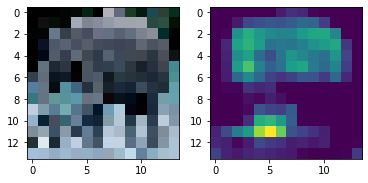

In [ ]:
original = cv2.resize(cv2.imread(ORIGINAL), (14, 14))
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((14, 14))
col=2
row=1
z = [original, heatmap]
fig = plt.figure(figsize=(6, 6))
for i in range(0, row*col):
  img = z[i]
  fig.add_subplot(row, col, i+1)
  plt.imshow(img)
plt.show()

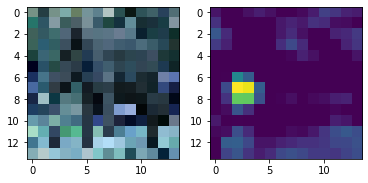

In [ ]:
original2 = cv2.resize(cv2.imread(ORIGINAL2), (14, 14))
heatmap2 = np.maximum(heatmap2, 0)
heatmap2 /= np.max(heatmap2)
heatmap2 = heatmap2.reshape((14, 14))
col=2
row=1
z = [original2, heatmap2]
fig = plt.figure(figsize=(6, 6))
for i in range(0, row*col):
  img = z[i]
  fig.add_subplot(row, col, i+1)
  plt.imshow(img)
plt.show()

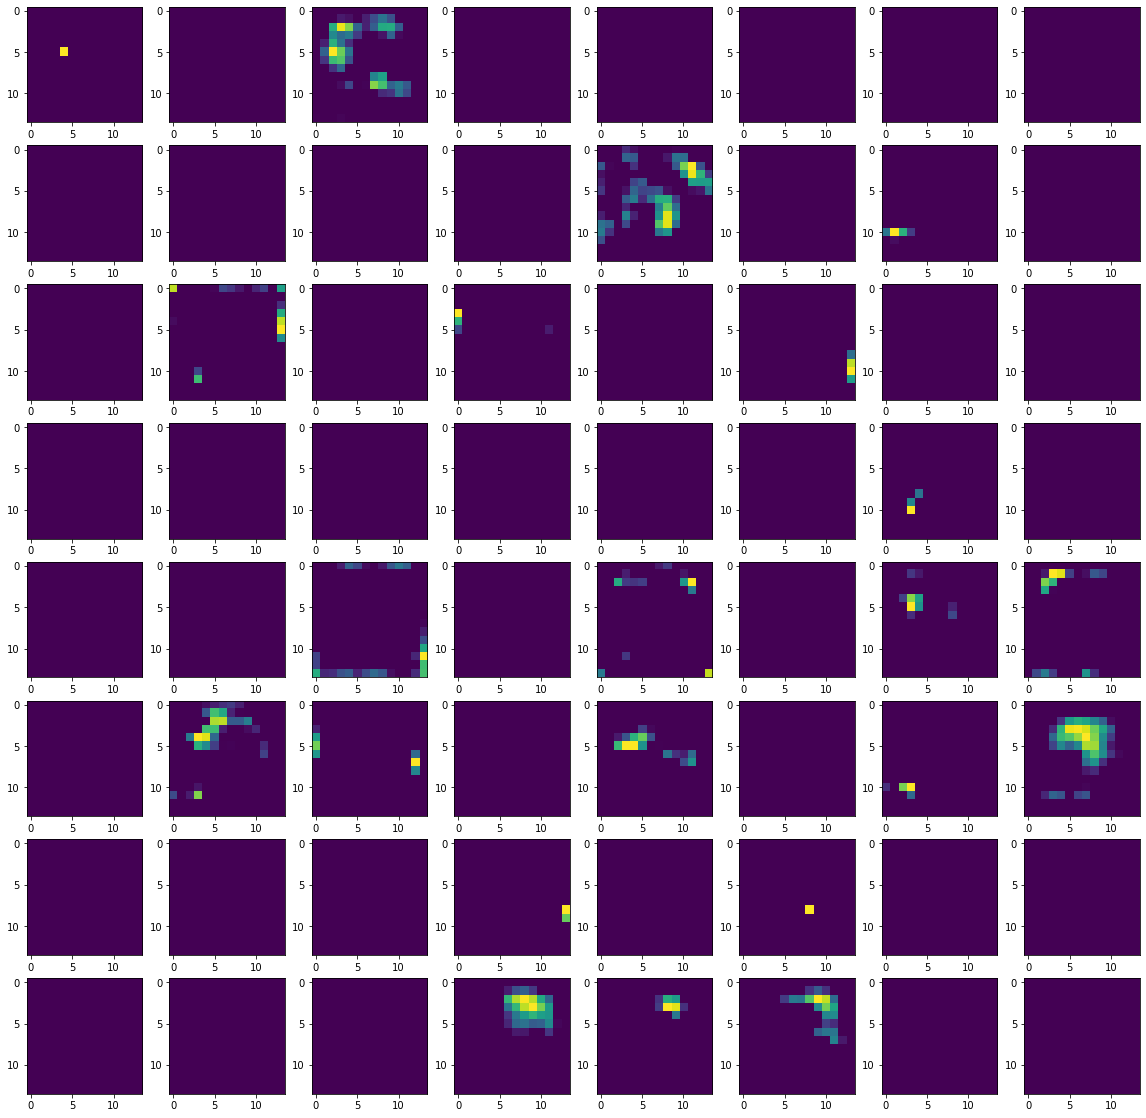

In [ ]:
heatmap_l = np.maximum(heatmap_l, 0)  # convert negative values to 0
heatmap_l /= np.max(heatmap_l)  # normalize
# plot the output from each block
row = 8
column = 8
fig = plt.figure(figsize=(20, 20))
for i in range(1, row*column + 1):
  img = heatmap_l[0, :, :, i-1]
  fig.add_subplot(row, column, i)
  plt.imshow(img)
plt.show()


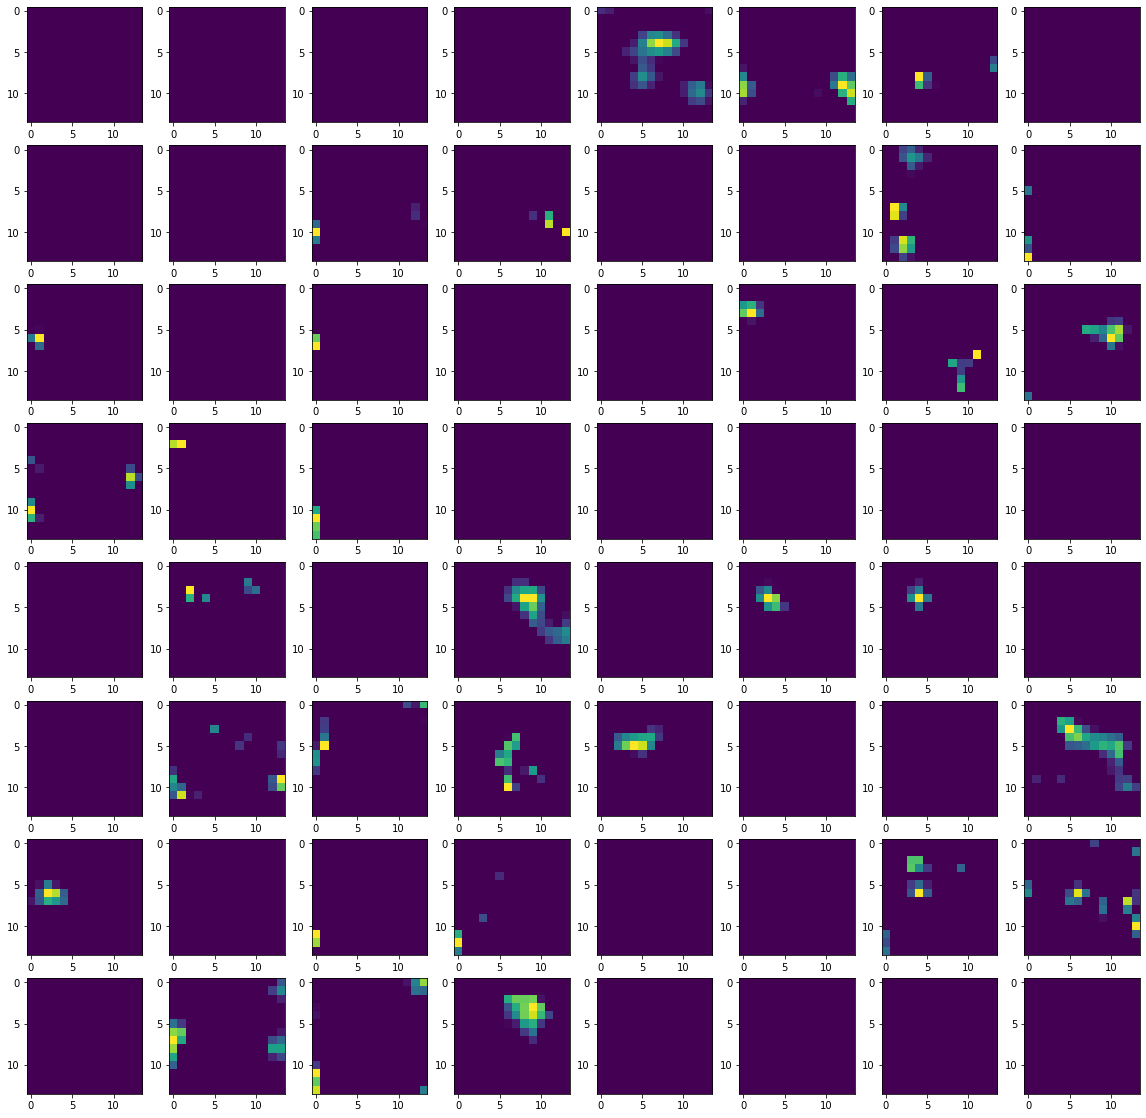

In [ ]:
heatmap_l2 = np.maximum(heatmap_l2, 0)  # convert negative values to 0
heatmap_l2 /= np.max(heatmap_l2)  # normalize
# plot the output from each block
row = 8
column = 8
fig = plt.figure(figsize=(20, 20))
for i in range(1, row*column + 1):
  img = heatmap_l2[0, :, :, i-1]
  fig.add_subplot(row, column, i)
  plt.imshow(img)
plt.show()

In [ ]:
# img = cv2.imread(ORIGINAL)

# INTENSITY = 0.5
# heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# # print(heatmap.shape[1])
# heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

# img = heatmap * INTENSITY + img

In [ ]:
# cv2_imshow(img)

In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('block3_conv3')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x) # for a given input predected output
  print("output shape", model_out.shape)
  print("layer shape", last_conv_layer.shape)
  class_out = model_out[:, np.argmax(model_out[0])]
  print("probablity of the predicted class", class_out)
  grads = tape.gradient(class_out, last_conv_layer)  # compute gradient based on predected probablity and class index
  print("Gradints of w.r.t predicted class", grads.shape) 
  pooled_grads = K.mean(grads, axis=(0, 1, 2))  # Global avarage pooling
  print("Global Avarage pooling", pooled_grads.shape)

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1) # heatmap by mean along with feature map axis
heatmap_l = (tf.multiply(pooled_grads, last_conv_layer)) # heatmap by mean along with feature map axis
print("heatmap shape", heatmap.shape, heatmap_l.shape)

output shape (1, 1000)
layer shape (1, 56, 56, 256)
probablity of the predicted class tf.Tensor([0.8383319], shape=(1,), dtype=float32)
Gradints of w.r.t predicted class (1, 56, 56, 256)
Global Avarage pooling (256,)
heatmap shape (1, 56, 56) (1, 56, 56, 256)


In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('block3_conv3')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x2) # for a given input predected output
  print("output shape", model_out.shape)
  print("layer shape", last_conv_layer.shape)
  class_out = model_out[:, np.argmax(model_out[0])]
  print("probablity of the predicted class", class_out)
  grads = tape.gradient(class_out, last_conv_layer)  # compute gradient based on predected probablity and class index
  print("Gradints of w.r.t predicted class", grads.shape) 
  pooled_grads = K.mean(grads, axis=(0, 1, 2))  # Global avarage pooling
  print("Global Avarage pooling", pooled_grads.shape)

heatmap2 = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1) # heatmap by mean along with feature map axis
heatmap_l2 = (tf.multiply(pooled_grads, last_conv_layer)) # heatmap by mean along with feature map axis
print("heatmap shape", heatmap2.shape, heatmap_l2.shape)

output shape (1, 1000)
layer shape (1, 56, 56, 256)
probablity of the predicted class tf.Tensor([0.6579515], shape=(1,), dtype=float32)
Gradints of w.r.t predicted class (1, 56, 56, 256)
Global Avarage pooling (256,)
heatmap shape (1, 56, 56) (1, 56, 56, 256)


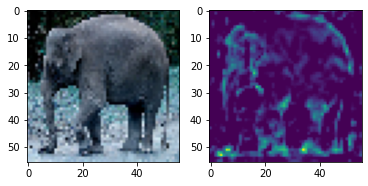

In [ ]:
original = cv2.resize(cv2.imread(ORIGINAL), (56, 56))
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((56, 56))
col=2
row=1
z = [original, heatmap]
fig = plt.figure(figsize=(6, 6))
for i in range(0, row*col):
  img = z[i]
  fig.add_subplot(row, col, i+1)
  plt.imshow(img)
plt.show()

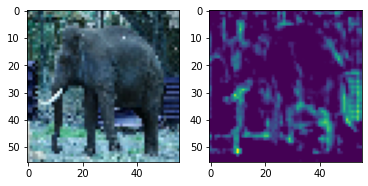

In [ ]:
original2 = cv2.resize(cv2.imread(ORIGINAL2), (56, 56))
heatmap2 = np.maximum(heatmap2, 0)
heatmap2 /= np.max(heatmap2)
heatmap2 = heatmap2.reshape((56, 56))
col=2
row=1
z = [original2, heatmap2]
fig = plt.figure(figsize=(6, 6))
for i in range(0, row*col):
  img = z[i]
  fig.add_subplot(row, col, i+1)
  plt.imshow(img)
plt.show()

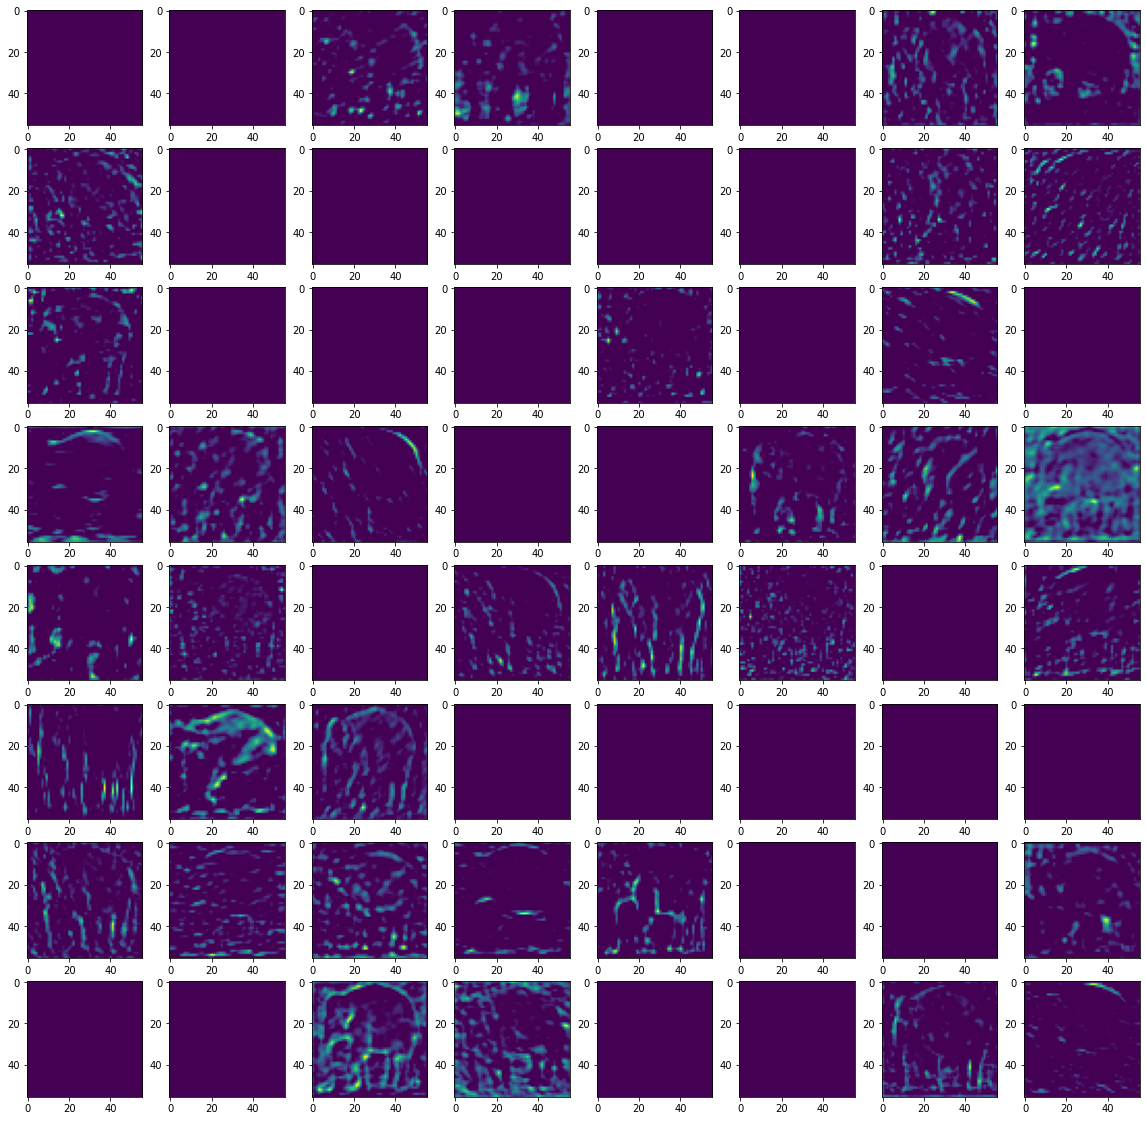

In [ ]:
heatmap_l = np.maximum(heatmap_l, 0)  # convert negative values to 0
heatmap_l /= np.max(heatmap_l)  # normalize
# plot the output from each block
row = 8
column = 8
fig = plt.figure(figsize=(20, 20))
for i in range(1, row*column + 1):
  img = heatmap_l[0, :, :, i-1]
  fig.add_subplot(row, column, i)
  plt.imshow(img)
plt.show()

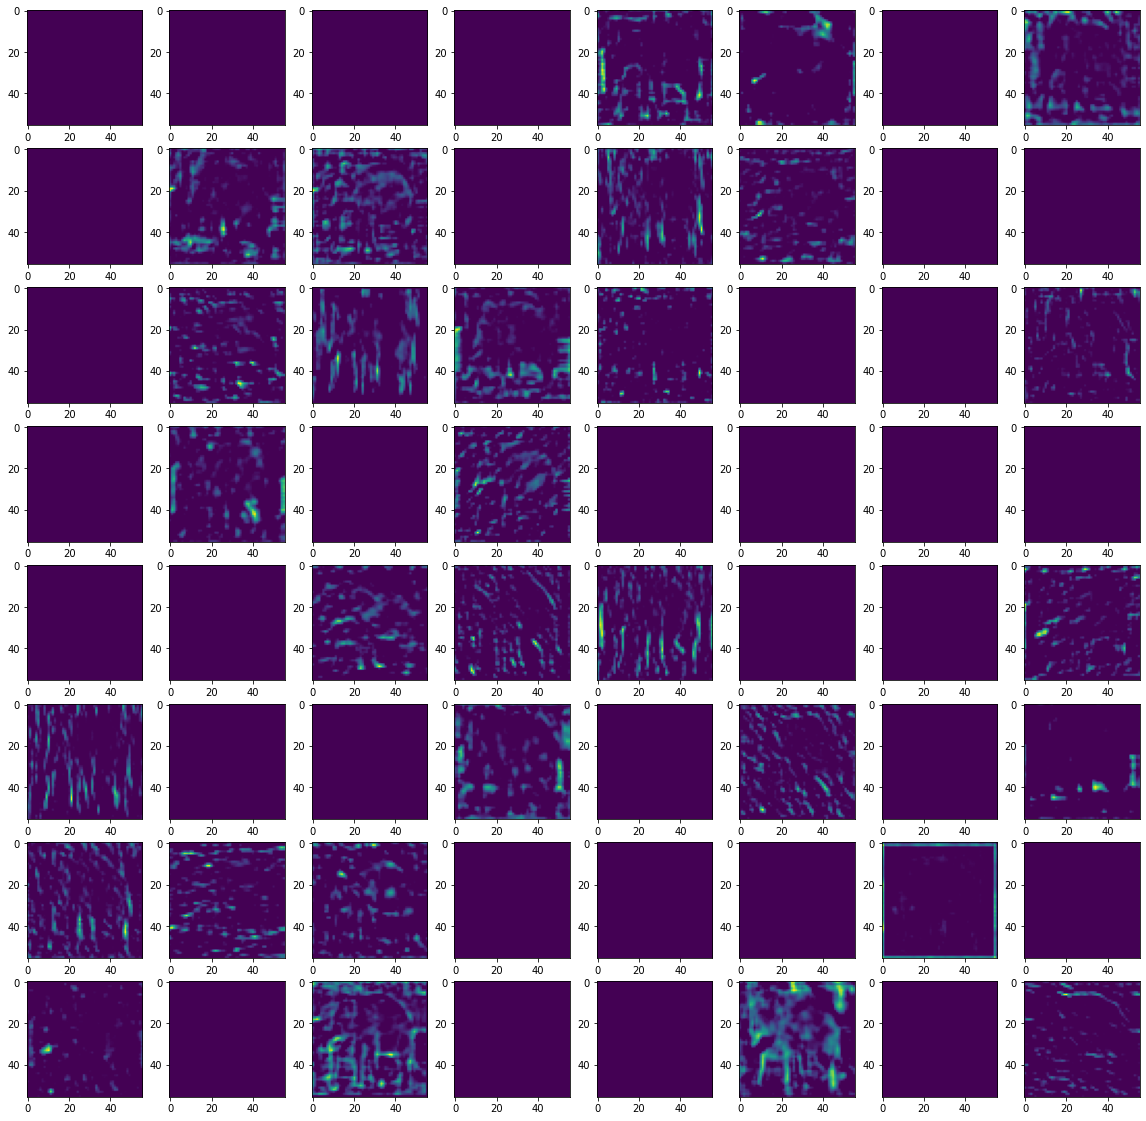

In [ ]:
heatmap_l2 = np.maximum(heatmap_l2, 0)  # convert negative values to 0
heatmap_l2 /= np.max(heatmap_l2)  # normalize
# plot the output from each block
row = 8
column = 8
fig = plt.figure(figsize=(20, 20))
for i in range(1, row*column + 1):
  img = heatmap_l2[0, :, :, i-1]
  fig.add_subplot(row, column, i)
  plt.imshow(img)
plt.show()

In [ ]:
# img = cv2.imread(ORIGINAL)

# INTENSITY = 0.5

# heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

# img = heatmap * INTENSITY + img

In [ ]:
# cv2_imshow(cv2.imread(ORIGINAL))
# cv2_imshow(img)

In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('block2_conv2')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x) # for a given input predected output
  print("output shape", model_out.shape)
  print("layer shape", last_conv_layer.shape)
  class_out = model_out[:, np.argmax(model_out[0])]
  print("probablity of the predicted class", class_out)
  grads = tape.gradient(class_out, last_conv_layer)  # compute gradient based on predected probablity and class index
  print("Gradints of w.r.t predicted class", grads.shape) 
  pooled_grads = K.mean(grads, axis=(0, 1, 2))  # Global avarage pooling
  print("Global Avarage pooling", pooled_grads.shape)

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1) # heatmap by mean along with feature map axis
heatmap_l = (tf.multiply(pooled_grads, last_conv_layer)) # heatmap by mean along with feature map axis
print("heatmap shape", heatmap.shape, heatmap_l.shape)

output shape (1, 1000)
layer shape (1, 112, 112, 128)
probablity of the predicted class tf.Tensor([0.8383319], shape=(1,), dtype=float32)
Gradints of w.r.t predicted class (1, 112, 112, 128)
Global Avarage pooling (128,)
heatmap shape (1, 112, 112) (1, 112, 112, 128)


In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('block2_conv2')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x2) # for a given input predected output
  print("output shape", model_out.shape)
  print("layer shape", last_conv_layer.shape)
  class_out = model_out[:, np.argmax(model_out[0])]
  print("probablity of the predicted class", class_out)
  grads = tape.gradient(class_out, last_conv_layer)  # compute gradient based on predected probablity and class index
  print("Gradints of w.r.t predicted class", grads.shape) 
  pooled_grads = K.mean(grads, axis=(0, 1, 2))  # Global avarage pooling
  print("Global Avarage pooling", pooled_grads.shape)

heatmap2 = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1) # heatmap by mean along with feature map axis
heatmap_l2 = (tf.multiply(pooled_grads, last_conv_layer)) # heatmap by mean along with feature map axis
print("heatmap shape", heatmap2.shape, heatmap_l2.shape)

output shape (1, 1000)
layer shape (1, 112, 112, 128)
probablity of the predicted class tf.Tensor([0.6579515], shape=(1,), dtype=float32)
Gradints of w.r.t predicted class (1, 112, 112, 128)
Global Avarage pooling (128,)
heatmap shape (1, 112, 112) (1, 112, 112, 128)


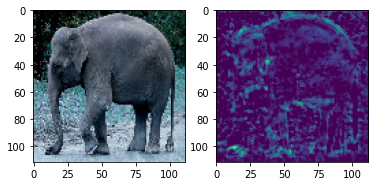

In [ ]:
original = cv2.resize(cv2.imread(ORIGINAL), (112, 112))
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((112, 112))
col=2
row=1
z = [original, heatmap]
fig = plt.figure(figsize=(6, 6))
for i in range(0, row*col):
  img = z[i]
  fig.add_subplot(row, col, i+1)
  plt.imshow(img)
plt.show()

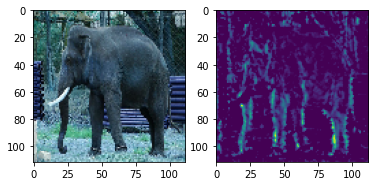

In [ ]:
original2 = cv2.resize(cv2.imread(ORIGINAL2), (112, 112))
heatmap2 = np.maximum(heatmap2, 0)
heatmap2 /= np.max(heatmap2)
heatmap2 = heatmap2.reshape((112, 112))
col=2
row=1
z = [original2, heatmap2]
fig = plt.figure(figsize=(6, 6))
for i in range(0, row*col):
  img = z[i]
  fig.add_subplot(row, col, i+1)
  plt.imshow(img)
plt.show()

In [ ]:
# img = cv2.imread(ORIGINAL)
# print(img.shape)
# INTENSITY = 0.5

# heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

# img = heatmap * INTENSITY + img

In [ ]:
# cv2_imshow(cv2.imread(ORIGINAL))
# cv2_imshow(img)

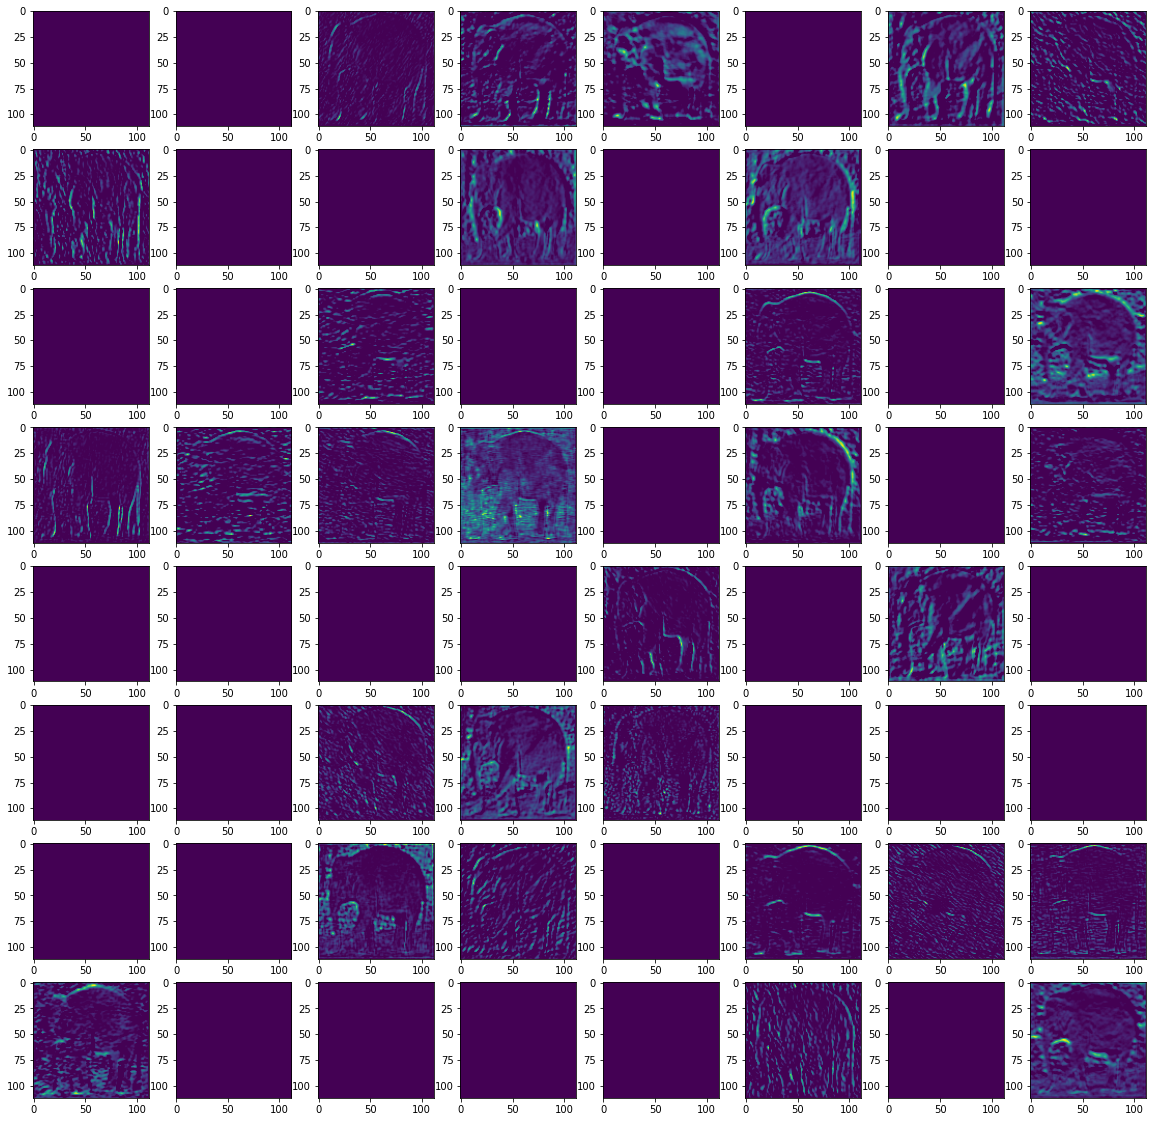

In [ ]:
heatmap_l = np.maximum(heatmap_l, 0)  # convert negative values to 0
heatmap_l /= np.max(heatmap_l)  # normalize
# plot the output from each block
row = 8
column = 8
fig = plt.figure(figsize=(20, 20))
for i in range(1, row*column + 1):
  img = heatmap_l[0, :, :, i-1]
  fig.add_subplot(row, column, i)
  plt.imshow(img)
plt.show()

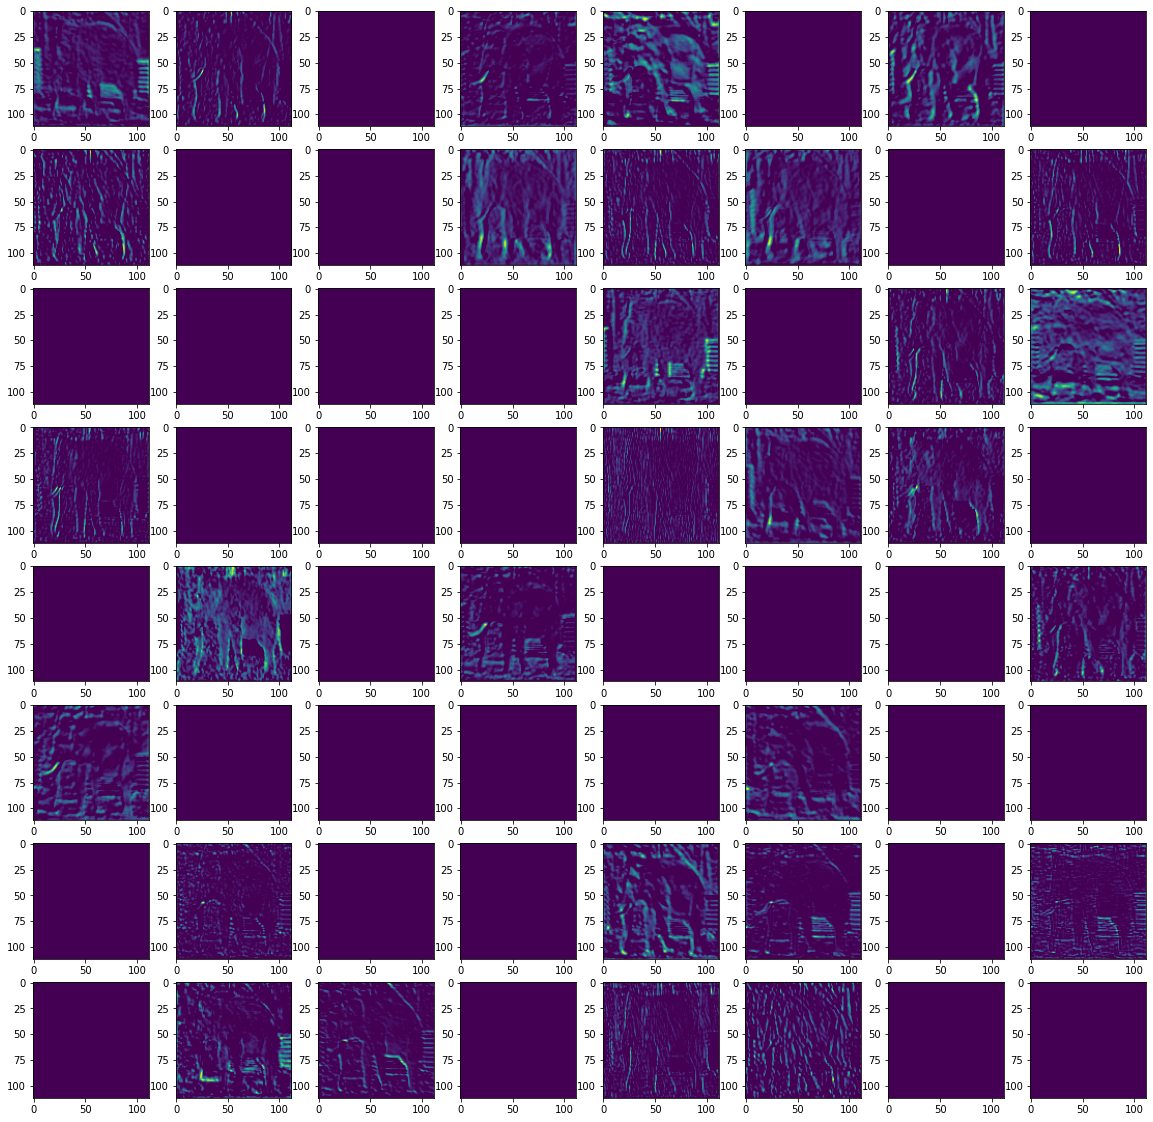

In [ ]:
heatmap_l2 = np.maximum(heatmap_l2, 0)  # convert negative values to 0
heatmap_l2 /= np.max(heatmap_l2)  # normalize
# plot the output from each block
row = 8
column = 8
fig = plt.figure(figsize=(20, 20))
for i in range(1, row*column + 1):
  img = heatmap_l2[0, :, :, i-1]
  fig.add_subplot(row, column, i)
  plt.imshow(img)
plt.show()

In [ ]:
!nvidia-smi

Fri Oct  1 06:23:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------